### Train Multilayer Perceptron Network - Handwritten Classification
https://lightning.ai/courses/deep-learning-fundamentals/training-multilayer-neural-networks-overview/4-3-training-a-multilayer-neural-network-in-pytorch-part-1-5/

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import tensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import dataset
import torchvision
from torchvision import datasets, transforms

#### Load the dataset

In [51]:
train_dataset = datasets.MNIST(root='./dataset/mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./dataset/mnist', train=False, transform=transforms.ToTensor(), download=False)
print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')

In [53]:
torch.manual_seed(1)

train_dataset, val_dataset = dataset.random_split(train_dataset, lengths=[55000, 5000])
print(f'Size of train dataset {len(train_dataset)}')
print(f'Size of validation dataset: {len(val_dataset)}')

Size of train dataset 55000
Size of validation dataset: 5000


In [54]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Examine Labels distribution

In [59]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())
    
print("\nTraining label distribution:")
print(sorted(train_counter.items()))

val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())
    
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validation label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


#### Zero-rule Classifier / Majority class Classifier

In [65]:
majority_class = test_counter.most_common(1)[0]
print(f'Majority class: {majority_class}')
total_test_examples = sum(test_counter.values())
baseline_accuracy = majority_class[1] / total_test_examples
print(f'Baseline accuracy: {baseline_accuracy * 100}%')

Majority class: (1, 1135)
Baseline accuracy: 11.35%


#### Visualize examples

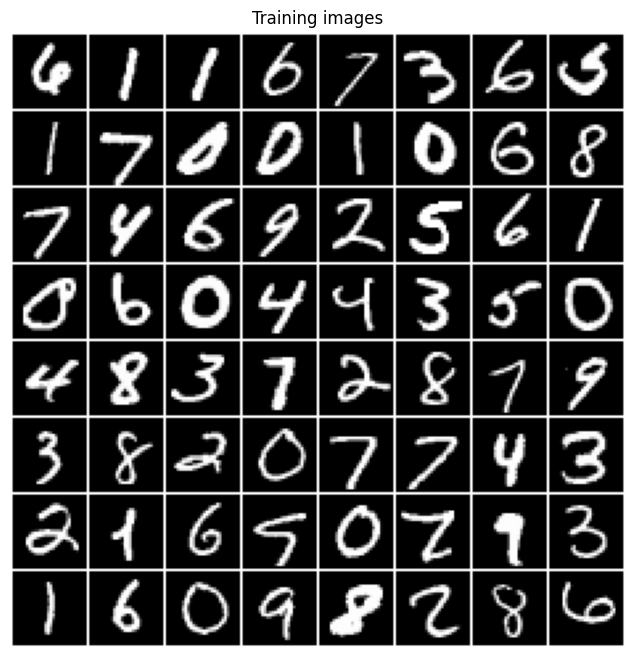

In [70]:
for images, labels in train_loader:
    break

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training images')
plt.imshow(np.transpose(
    torchvision.utils.make_grid(
        images,
        padding=1, # padding pixel between image
        pad_value=1.0,
        normalize=True # normalize pixel values of images to [0,1]
    ),
    (1,2,0)
))
plt.show()

#### Implement the Model

Examine how an image represented in PyTorch tensor<br>
https://discuss.pytorch.org/t/what-is-image-really/151290

In [82]:
images.shape 
# => torch.Size([64, 1, 28, 28]): batch_size, channel, height, width

# flatten from dimension 1, ofcause
torch.flatten(images, start_dim=1).shape
# => torch.Size([64, 784]): batch_size, features
# so we have 784 input features

torch.Size([64, 784])

Define the Model

In [92]:
class MNISTMultilayerPerceptron(torch.nn.Module):
    def __init__(self, n_input_features, n_output_classes):
        super().__init__()
        
        layer1_outputs = 50
        layer2_outputs = 25
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_input_features, layer1_outputs),
            torch.nn.ReLU(),

            torch.nn.Linear(layer1_outputs, layer2_outputs),
            torch.nn.ReLU(),

            torch.nn.Linear(layer2_outputs, n_output_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.layers(x)
        return logits

#### Training

In [100]:
class TrainHistory:
    def __init__(self):
        self.epochs = []
        self.batches = []
        self.train_losses = []
        self.train_accs = []
        self.val_accs = []

In [110]:
class Trainer:
    def __init__(self, model):
        self.model = model

    def train(self, train_loader, val_loader, epochs, learning_rate):
        train_hist = TrainHistory()

        torch.manual_seed(1)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            train_hist.epochs.append(epoch+1)

            self.model = self.model.train()
            for idx, (x_batch, y_batch) in enumerate(train_loader):
                train_hist.batches.append(idx+1)

                logits = self.model(x_batch)
                loss = F.cross_entropy(logits, y_batch)
                train_hist.train_losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward() # backpropagation
                optimizer.step() # update the model (weights)

                print(f"Epoch {epoch+1:03d}/{epochs:03d} - Batch {idx+1:03d}/{len(train_loader):03d} - Loss {loss:.2f}")
            
            train_acc = self.compute_accuracy(train_loader)
            val_acc = self.compute_accuracy(val_loader)
            train_hist.train_accs.append(train_acc)
            train_hist.val_accs.append(val_acc)
            print(f"Train Accuracy {train_acc*100:02f} - Val Accuracy {val_acc*100:02f}")
        
        return train_hist

    def compute_accuracy(self, dataloader):
        correct = 0
        total_examples = 0 

        self.model = self.model.eval()
        for idx, (x_batch, y_batch) in enumerate(dataloader): # use dataloader in case dataset is large
            with torch.inference_mode(): # the same as torch.no_grad
                logits = self.model(x_batch)
                # print(f'{idx} logits: {logits}')
            predictions = torch.argmax(logits, dim=1)
            # print(f'{idx} predictions: {predictions}')
            compare = y_batch == predictions
            correct += torch.sum(compare)
            total_examples += len(compare)
        
        return correct / total_examples

In [111]:
epochs = 10
learning_rate = 0.05

model = MNISTMultilayerPerceptron(784, 10)
trainer = Trainer(model)
train_hist = trainer.train(train_loader, val_loader, epochs=epochs, learning_rate=learning_rate)

Epoch 001/010 - Batch 001/860 - Loss 2.29
Epoch 001/010 - Batch 002/860 - Loss 2.29
Epoch 001/010 - Batch 003/860 - Loss 2.31
Epoch 001/010 - Batch 004/860 - Loss 2.31
Epoch 001/010 - Batch 005/860 - Loss 2.33
Epoch 001/010 - Batch 006/860 - Loss 2.32
Epoch 001/010 - Batch 007/860 - Loss 2.30
Epoch 001/010 - Batch 008/860 - Loss 2.33
Epoch 001/010 - Batch 009/860 - Loss 2.34
Epoch 001/010 - Batch 010/860 - Loss 2.27
Epoch 001/010 - Batch 011/860 - Loss 2.30
Epoch 001/010 - Batch 012/860 - Loss 2.30
Epoch 001/010 - Batch 013/860 - Loss 2.32
Epoch 001/010 - Batch 014/860 - Loss 2.30
Epoch 001/010 - Batch 015/860 - Loss 2.29
Epoch 001/010 - Batch 016/860 - Loss 2.29
Epoch 001/010 - Batch 017/860 - Loss 2.31
Epoch 001/010 - Batch 018/860 - Loss 2.32
Epoch 001/010 - Batch 019/860 - Loss 2.28
Epoch 001/010 - Batch 020/860 - Loss 2.31
Epoch 001/010 - Batch 021/860 - Loss 2.30
Epoch 001/010 - Batch 022/860 - Loss 2.31
Epoch 001/010 - Batch 023/860 - Loss 2.28
Epoch 001/010 - Batch 024/860 - Lo

#### Evaluate the Model

In [112]:
train_acc = trainer.compute_accuracy(train_loader)
val_acc = trainer.compute_accuracy(val_loader)
test_acc = trainer.compute_accuracy(test_loader)

print(f"Train Accuracy {train_acc*100:02f} - Val Accuracy {val_acc*100:02f} - Test Accuracy {test_acc*100:02f}")

Train Accuracy 97.576363 - Val Accuracy 96.060005 - Test Accuracy 96.500000


#### Plot the loss

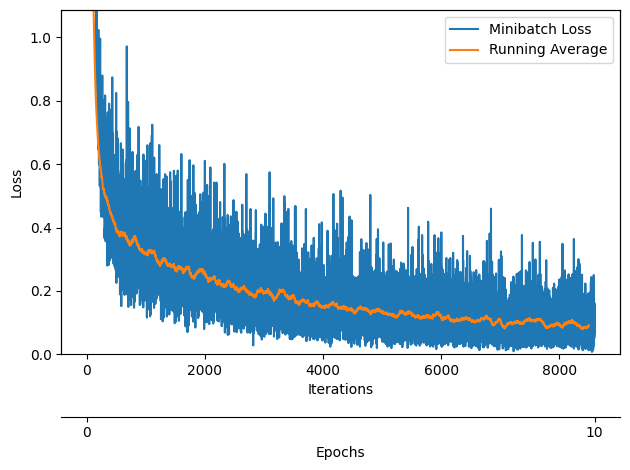

In [113]:
import helper_plotting
helper_plotting.plot_training_loss(
    minibatch_loss_list=train_hist.train_losses, 
    num_epochs=epochs, 
    iter_per_epoch=len(train_hist.train_losses) // epochs)

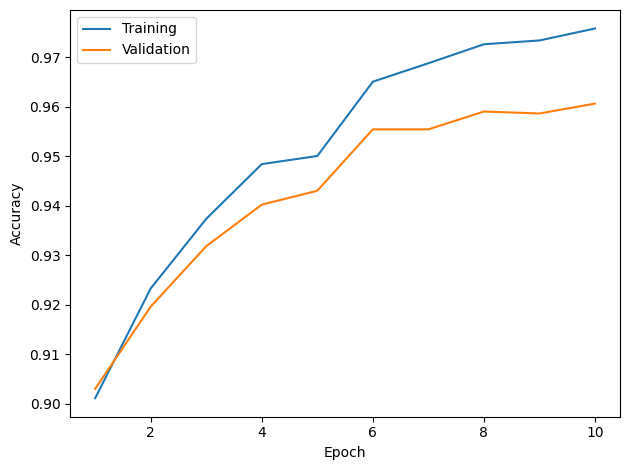

In [115]:
helper_plotting.plot_accuracy(train_hist.train_accs, train_hist.val_accs, '.')